<a href="https://colab.research.google.com/github/mohamedtal/PFE2021/blob/main/28_03_2021_task1_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os
import random
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras import layers
from keras.applications.resnet50 import ResNet50
from keras.applications import DenseNet121
from keras.utils import Sequence
from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

In [ ]:
# before all don't forget to use the GPU

# at first we need to get the dataset from the drive 
# pfe2021.1@gmail.com		zakimoha123
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#unzip the dataset

# for the train
!unzip /content/drive/MyDrive/dataset/batchesTest.zip

In [ ]:
def preprocessFunction(image):
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    kopya = image.copy()
    kopya = cv2.cvtColor(kopya,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(kopya,(5,5),0)
    thresh = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1]
    kontur = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    kontur = kontur[0][0]
    kontur = kontur[:,0,:]
    x1 = tuple(kontur[kontur[:,0].argmin()])[0]
    x2 = tuple(kontur[kontur[:,0].argmax()])[0]
    y1 = tuple(kontur[kontur[:,1].argmin()])[1]
    y2 = tuple(kontur[kontur[:,1].argmax()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*5//50
    kopya2 = image.copy()
    if x2-x1>100 and y2-y1>100 :
        kopya2 = kopya2[y1+y:y2-y , x1+x:x2-x]
        kopya2 = cv2.resize(kopya2,(1024,1024))
    lab = cv2.cvtColor(kopya2,cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0,tileGridSize=((8,8)))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    son = cv2.cvtColor(limg,cv2.COLOR_LAB2RGB)
    med_son = cv2.medianBlur(son,3)
    arka_plan = cv2.medianBlur(son,37)
    maske = cv2.addWeighted(med_son,1,arka_plan,-1,255)
    son_img = cv2.bitwise_and(maske,med_son)
    return son_img

In [ ]:
# creating the batches folder
path_batch_train = 'batchesTrain'
path_batch_test = 'batchesTest'

def createBatchFolder(pathName):
    try:
        os.mkdir(pathName)
    except OSError:
        print ("Creation of the directory %s failed" % pathName)
    else:
        print ("Successfully created the directory %s " % pathName)
    finally:
        for i in range(1,17):
          try:
              pathBatch = pathName+'/'+str(i)
              os.mkdir(pathBatch)
          except OSError:
              print ("Creation of the directory %s failed" % pathName)
          finally:
            for j in range(5):
              try:
                  pathClass = pathBatch+'/'+ str(j)
                  os.mkdir(pathClass)
              except OSError:
                  print ("Creation of the directory %s failed" % pathName)
# call the create path function
createBatchFolder(path_batch_train)
createBatchFolder(path_batch_test)

Successfully created the directory batchesTrain 
Successfully created the directory batchesTest 


In [ ]:
#read images, do division, save results batches
path = 'DR-dataset/train/'
numberTrainImagesPerClass = 600
numberTestImagesPerClass = 100
size_batch = 255
sizeOfOriginalImage = 1024
numberOfClass = 5

def createBatches(path,path_batch,path_test,numberTrainImagesPerClass,numberTestImagesPerClass,size_batch,sizeOfOriginalImage,numberOfClass):
    numberOfBatch = sizeOfOriginalImage // size_batch
    for c in range(numberOfClass):
      # the path of each class
      path_class = path + str(c)
      # get the list of images in each class
      list_images =  os.listdir(path_class)
      # choose randomly 300 images from the previous list
      choosed_images = random.sample(list_images, numberTrainImagesPerClass+numberTestImagesPerClass)
      # get train dataset
      for k in range(numberTrainImagesPerClass):
        # get the path of each image
        image = choosed_images[k]
        path_image = path_class+'/'+ image
        # read the image
        img = cv2.imread(path_image)
        try:
          img = preprocessFunction(img)
        except:
          pass
        img = cv2.resize(img, dsize=(sizeOfOriginalImage, sizeOfOriginalImage))
        numeroBatch = 1
        for i in range(numberOfBatch):
          for j in range(numberOfBatch):
            batch = img[i*size_batch:i*size_batch+size_batch,j*size_batch:j*size_batch+size_batch,:]
            try:
                newPath = path_batch+'/'+str(numeroBatch)+'/'+str(c)+'/'+image
                cv2.imwrite(newPath,batch)
            except Exception as e:
                print(img.shape)
                print('error_train'+str(e))
            numeroBatch = numeroBatch + 1
      # get the test dataset
      for k in range(numberTrainImagesPerClass,numberTrainImagesPerClass+numberTestImagesPerClass):
        # get the path of each image
        image = choosed_images[k]
        path_image = path_class+'/'+image
        # read the image
        img = cv2.imread(path_image)
        img = preprocessFunction(img)
        img = cv2.resize(img, dsize=(sizeOfOriginalImage, sizeOfOriginalImage))
        numeroBatch = 1
        for i in range(numberOfBatch):
          for j in range(numberOfBatch):
            batch = img[i*size_batch:i*size_batch+size_batch,j*size_batch:j*size_batch+size_batch,:]
            try:
                newPath = path_test+'/'+str(numeroBatch)+'/'+str(c)+'/'+image
                cv2.imwrite(newPath,batch)
            except Exception as e: 
                print('error_test'+str(e))
            numeroBatch = numeroBatch + 1

createBatches(path,path_batch_train,path_batch_test,numberTrainImagesPerClass,numberTestImagesPerClass,size_batch,sizeOfOriginalImage,numberOfClass)

In [ ]:

!ls batchesTrain/2/0 | wc -l
!ls batchesTest/2/0 | wc -l

600
100


In [ ]:
# augmenttaion
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import os
import cv2
%matplotlib inline

for i in range(1,17):
  for j in range(5):
    BASE_DIR = "batchesTrain/"+str(i)+'/'+str(j)
    NEW_DIR= "batchesTrain/"+str(i)+'/'+str(j)
    list_dir =  os.listdir(BASE_DIR)
    from google.colab.patches import cv2_imshow
    for images in list_dir:
        image = cv2.imread(BASE_DIR + "/"+ images)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            
        #rotation
        rotate=iaa.Affine(rotate=(0, 30))
        rotated_image=rotate.augment_image(image)
        cv2.imwrite(NEW_DIR + "/" + 'rotated-'+images,rotated_image)

        #zoom
        crop = iaa.Crop(percent=(0.07, 0.12)) # crop image
        corp_image=crop.augment_image(image)
        cv2.imwrite(NEW_DIR + "/" + 'zoomed-'+images,corp_image)

        #shear
        crop = iaa.Affine(shear=10)
        corp_image=crop.augment_image(image)
        cv2.imwrite(NEW_DIR + "/" + 'affine-'+images,corp_image)

        #flip H
        flip_hr=iaa.Fliplr(p=1.0)
        flip_hr_image= flip_hr.augment_image(image)
        cv2.imwrite(NEW_DIR + "/" + 'fliph-'+images,flip_hr_image)


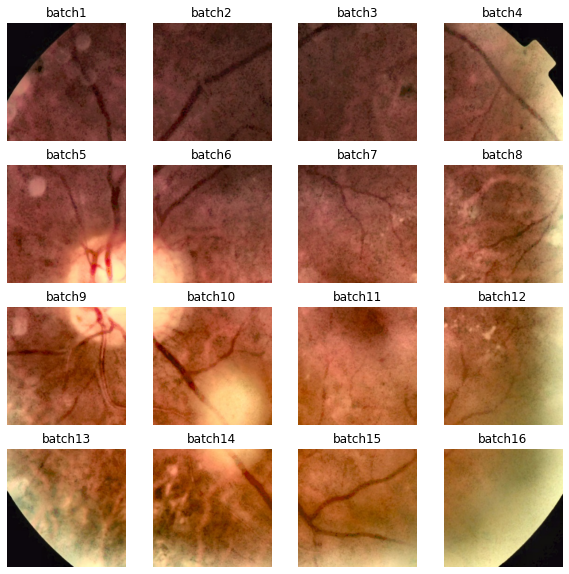

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


fig = plt.figure(figsize=(10, 10)) 
  
# setting values to rows and column variables 
rows = 4
columns = 4

for i in range(1,17):
  # Adds a subplot at the 1st position 
  image = mpimg.imread('batchesTrain/'+str(i)+'/4/10785_left.jpg')
  image = cv2.resize(image,(224,224))
  fig.add_subplot(rows, columns, i) 
  # showing image 
  plt.imshow(image) 
  plt.axis('off') 
  plt.title("batch"+str(i)) 

In [ ]:
def createModel():
  pre_trained_model = DenseNet121(input_shape = (224,224,3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

  model = Sequential()
  model.add(pre_trained_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizers.Adam(lr=0.00005),
      metrics=['accuracy']
  )
  return model

batchesTrain/1/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/35
398/398 [==============================] - 73s 157ms/step - loss: 2.1913 - accuracy: 0.2285 - val_loss: 1.5254 - val_accuracy: 0.3393

Epoch 00001: val_loss improved from inf to 1.52538, saving model to drive/MyDrive/models/modelBatch1.h5
Epoch 2/35
398/398 [==============================] - 61s 153ms/step - loss: 1.7860 - accuracy: 0.3088 - val_loss: 1.3720 - val_accuracy: 0.4156

Epoch 00002: val_loss improved from 1.52538 to 1.37204, saving model to drive/MyDrive/models/modelBatch1.h5
Epoch 3/35
398/398 [==============================] - 61s 154ms/step - loss: 1.6350 - accuracy: 0.3495 - val_loss: 1.3107 - val_accuracy: 0.4384

Epoch 00003: val_loss improved from 1.37204 to 1.31065, saving model to drive/MyDrive/models/modelBatch1.h5
Epoch 4/35
398/398 [==============================] - 61s 154ms/step - loss: 1.5249 - accuracy: 0.3925 - val_loss: 1.2543 - val_accuracy: 0.4759

Epoch 00004: val_loss improved from 1.31065 to 1.25427, saving model to drive/MyDrive/models/mod

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.



Epoch 00035: val_loss did not improve from 0.50036


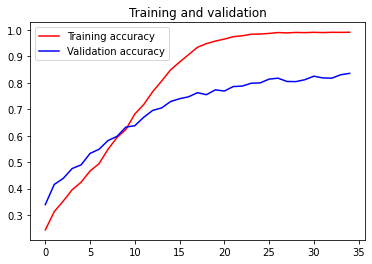

<Figure size 432x288 with 0 Axes>

batchesTrain/2/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 73s 156ms/step - loss: 2.1899 - accuracy: 0.2435 - val_loss: 1.4909 - val_accuracy: 0.3634

Epoch 00001: val_loss improved from inf to 1.49095, saving model to drive/MyDrive/models/modelBatch2.h5
Epoch 2/35
398/398 [==============================] - 60s 151ms/step - loss: 1.7333 - accuracy: 0.3201 - val_loss: 1.3607 - val_accuracy: 0.4205

Epoch 00002: val_loss improved from 1.49095 to 1.36070, saving model to drive/MyDrive/models/modelBatch2.h5
Epoch 3/35
398/398 [==============================] - 60s 151ms/step - loss: 1.5829 - accuracy: 0.3625 - val_loss: 1.2852 - val_accuracy: 0.4504

Epoch 00003: val_loss improved from 1.36070 to 1.28525, saving model to drive/MyDrive/models/modelBatch2.h5
Epoch 4/35
398/398 [==============================] - 60s 150ms/step - loss: 1.4815 - accuracy: 0.4005 - val_loss: 1.2383 - val_accuracy: 0.4

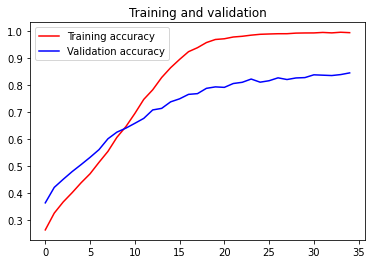

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[ 91  98  99  78  84]
 [ 91  69 107  98  85]
 [ 75 108 110  83  74]
 [ 85  85 105  73 102]
 [ 96  75 102  96  81]]
              precision    recall  f1-score   support

           0       0.21      0.20      0.20       450
           1       0.16      0.15      0.16       450
           2       0.21      0.24      0.23       450
           3       0.17      0.16      0.17       450
           4       0.19      0.18      0.18       450

    accuracy                           0.19      2250
   macro avg       0.19      0.19      0.19      2250
weighted avg       0.19      0.19      0.19      2250

batchesTrain/3/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 75s 161ms/step - loss: 2.1696 - accuracy: 0.2406 - val_loss: 1.5438 - val_accuracy: 0.3464

Epoch 00001: val_loss improved from inf to 1.54382, saving model to drive/MyDrive/models/modelBatch3.h5
Epoch 2/35
398/398 [========================

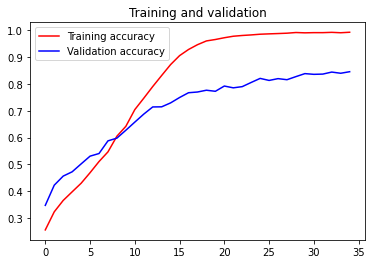

<Figure size 432x288 with 0 Axes>

batchesTrain/4/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 75s 160ms/step - loss: 2.0944 - accuracy: 0.2294 - val_loss: 1.4749 - val_accuracy: 0.3446

Epoch 00001: val_loss improved from inf to 1.47487, saving model to drive/MyDrive/models/modelBatch4.h5
Epoch 2/35
398/398 [==============================] - 60s 150ms/step - loss: 1.7131 - accuracy: 0.3141 - val_loss: 1.3265 - val_accuracy: 0.4277

Epoch 00002: val_loss improved from 1.47487 to 1.32653, saving model to drive/MyDrive/models/modelBatch4.h5
Epoch 3/35
398/398 [==============================] - 60s 150ms/step - loss: 1.5617 - accuracy: 0.3656 - val_loss: 1.2729 - val_accuracy: 0.4621

Epoch 00003: val_loss improved from 1.32653 to 1.27287, saving model to drive/MyDrive/models/modelBatch4.h5
Epoch 4/35
398/398 [==============================] - 60s 150ms/step - loss: 1.4555 - accuracy: 0.4121 - val_loss: 1.2151 - val_accuracy: 0.4

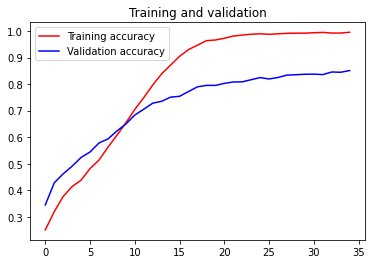

<Figure size 432x288 with 0 Axes>

batchesTrain/5/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 76s 164ms/step - loss: 2.2508 - accuracy: 0.2196 - val_loss: 1.5297 - val_accuracy: 0.3455

Epoch 00001: val_loss improved from inf to 1.52975, saving model to drive/MyDrive/models/modelBatch5.h5
Epoch 2/35
398/398 [==============================] - 60s 151ms/step - loss: 1.7267 - accuracy: 0.3126 - val_loss: 1.3911 - val_accuracy: 0.3911

Epoch 00002: val_loss improved from 1.52975 to 1.39109, saving model to drive/MyDrive/models/modelBatch5.h5
Epoch 3/35
398/398 [==============================] - 60s 151ms/step - loss: 1.6216 - accuracy: 0.3457 - val_loss: 1.3326 - val_accuracy: 0.4268

Epoch 00003: val_loss improved from 1.39109 to 1.33255, saving model to drive/MyDrive/models/modelBatch5.h5
Epoch 4/35
398/398 [==============================] - 60s 151ms/step - loss: 1.5104 - accuracy: 0.3883 - val_loss: 1.2851 - val_accuracy: 0.4

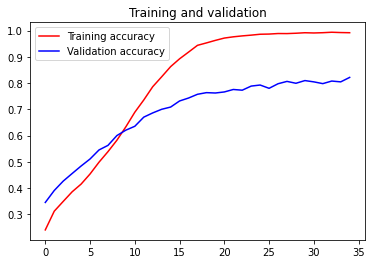

<Figure size 432x288 with 0 Axes>

batchesTrain/6/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 75s 161ms/step - loss: 2.1692 - accuracy: 0.2293 - val_loss: 1.4953 - val_accuracy: 0.3335

Epoch 00001: val_loss improved from inf to 1.49526, saving model to drive/MyDrive/models/modelBatch6.h5
Epoch 2/35
398/398 [==============================] - 60s 151ms/step - loss: 1.7538 - accuracy: 0.3191 - val_loss: 1.3770 - val_accuracy: 0.3906

Epoch 00002: val_loss improved from 1.49526 to 1.37702, saving model to drive/MyDrive/models/modelBatch6.h5
Epoch 3/35
398/398 [==============================] - 60s 151ms/step - loss: 1.6579 - accuracy: 0.3452 - val_loss: 1.3154 - val_accuracy: 0.4286

Epoch 00003: val_loss improved from 1.37702 to 1.31542, saving model to drive/MyDrive/models/modelBatch6.h5
Epoch 4/35
398/398 [==============================] - 60s 150ms/step - loss: 1.5268 - accuracy: 0.3883 - val_loss: 1.2494 - val_accuracy: 0.4

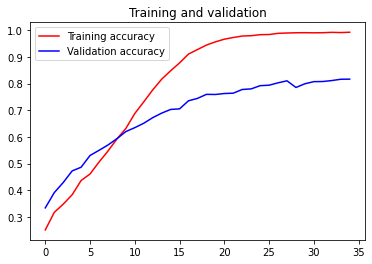

<Figure size 432x288 with 0 Axes>

batchesTrain/7/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 74s 158ms/step - loss: 2.2595 - accuracy: 0.2323 - val_loss: 1.5498 - val_accuracy: 0.3496

Epoch 00001: val_loss improved from inf to 1.54978, saving model to drive/MyDrive/models/modelBatch7.h5
Epoch 2/35
398/398 [==============================] - 60s 150ms/step - loss: 1.7864 - accuracy: 0.3071 - val_loss: 1.3868 - val_accuracy: 0.4165

Epoch 00002: val_loss improved from 1.54978 to 1.38678, saving model to drive/MyDrive/models/modelBatch7.h5
Epoch 3/35
398/398 [==============================] - 60s 151ms/step - loss: 1.6278 - accuracy: 0.3474 - val_loss: 1.3255 - val_accuracy: 0.4460

Epoch 00003: val_loss improved from 1.38678 to 1.32554, saving model to drive/MyDrive/models/modelBatch7.h5
Epoch 4/35
398/398 [==============================] - 60s 150ms/step - loss: 1.5410 - accuracy: 0.3819 - val_loss: 1.2800 - val_accuracy: 0.4

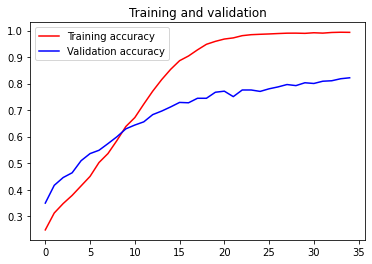

<Figure size 432x288 with 0 Axes>

batchesTrain/8/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 74s 159ms/step - loss: 2.1816 - accuracy: 0.2361 - val_loss: 1.5363 - val_accuracy: 0.3250

Epoch 00001: val_loss improved from inf to 1.53627, saving model to drive/MyDrive/models/modelBatch8.h5
Epoch 2/35
398/398 [==============================] - 60s 149ms/step - loss: 1.7583 - accuracy: 0.3186 - val_loss: 1.3715 - val_accuracy: 0.3978

Epoch 00002: val_loss improved from 1.53627 to 1.37145, saving model to drive/MyDrive/models/modelBatch8.h5
Epoch 3/35
398/398 [==============================] - 59s 149ms/step - loss: 1.6459 - accuracy: 0.3452 - val_loss: 1.3104 - val_accuracy: 0.4375

Epoch 00003: val_loss improved from 1.37145 to 1.31042, saving model to drive/MyDrive/models/modelBatch8.h5
Epoch 4/35
398/398 [==============================] - 59s 149ms/step - loss: 1.5210 - accuracy: 0.3877 - val_loss: 1.2576 - val_accuracy: 0.4

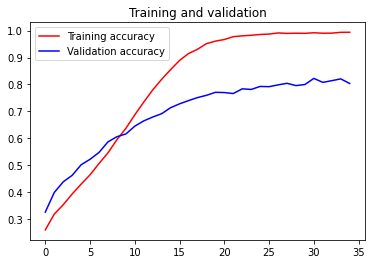

<Figure size 432x288 with 0 Axes>

batchesTrain/9/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 75s 161ms/step - loss: 2.1315 - accuracy: 0.2296 - val_loss: 1.4718 - val_accuracy: 0.3571

Epoch 00001: val_loss improved from inf to 1.47185, saving model to drive/MyDrive/models/modelBatch9.h5
Epoch 2/35
398/398 [==============================] - 60s 150ms/step - loss: 1.7585 - accuracy: 0.3028 - val_loss: 1.3662 - val_accuracy: 0.4040

Epoch 00002: val_loss improved from 1.47185 to 1.36622, saving model to drive/MyDrive/models/modelBatch9.h5
Epoch 3/35
398/398 [==============================] - 59s 149ms/step - loss: 1.6380 - accuracy: 0.3447 - val_loss: 1.3016 - val_accuracy: 0.4379

Epoch 00003: val_loss improved from 1.36622 to 1.30159, saving model to drive/MyDrive/models/modelBatch9.h5
Epoch 4/35
398/398 [==============================] - 59s 149ms/step - loss: 1.5319 - accuracy: 0.3858 - val_loss: 1.2426 - val_accuracy: 0.4

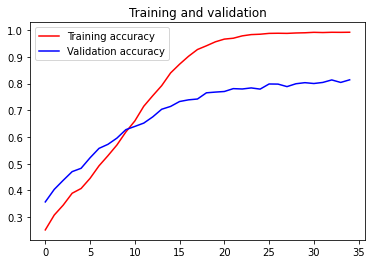

<Figure size 432x288 with 0 Axes>

batchesTrain/10/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 75s 162ms/step - loss: 2.1936 - accuracy: 0.2203 - val_loss: 1.5223 - val_accuracy: 0.3366

Epoch 00001: val_loss improved from inf to 1.52228, saving model to drive/MyDrive/models/modelBatch10.h5
Epoch 2/35
398/398 [==============================] - 59s 149ms/step - loss: 1.7444 - accuracy: 0.3004 - val_loss: 1.3895 - val_accuracy: 0.3982

Epoch 00002: val_loss improved from 1.52228 to 1.38952, saving model to drive/MyDrive/models/modelBatch10.h5
Epoch 3/35
398/398 [==============================] - 60s 150ms/step - loss: 1.6312 - accuracy: 0.3290 - val_loss: 1.3303 - val_accuracy: 0.4317

Epoch 00003: val_loss improved from 1.38952 to 1.33026, saving model to drive/MyDrive/models/modelBatch10.h5
Epoch 4/35
398/398 [==============================] - 59s 149ms/step - loss: 1.5482 - accuracy: 0.3728 - val_loss: 1.2813 - val_accuracy:

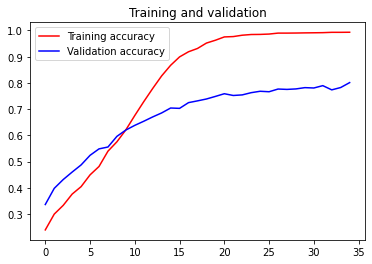

<Figure size 432x288 with 0 Axes>

batchesTrain/11/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 74s 160ms/step - loss: 2.1855 - accuracy: 0.2138 - val_loss: 1.5339 - val_accuracy: 0.3290

Epoch 00001: val_loss improved from inf to 1.53392, saving model to drive/MyDrive/models/modelBatch11.h5
Epoch 2/35
398/398 [==============================] - 60s 149ms/step - loss: 1.7732 - accuracy: 0.2859 - val_loss: 1.4229 - val_accuracy: 0.3714

Epoch 00002: val_loss improved from 1.53392 to 1.42290, saving model to drive/MyDrive/models/modelBatch11.h5
Epoch 3/35
398/398 [==============================] - 60s 150ms/step - loss: 1.6717 - accuracy: 0.3112 - val_loss: 1.3654 - val_accuracy: 0.4062

Epoch 00003: val_loss improved from 1.42290 to 1.36536, saving model to drive/MyDrive/models/modelBatch11.h5
Epoch 4/35
398/398 [==============================] - 59s 149ms/step - loss: 1.5617 - accuracy: 0.3646 - val_loss: 1.3125 - val_accuracy:

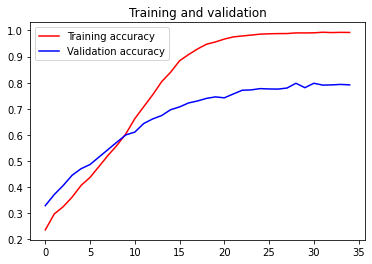

<Figure size 432x288 with 0 Axes>

batchesTrain/12/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 73s 156ms/step - loss: 2.1896 - accuracy: 0.2217 - val_loss: 1.5139 - val_accuracy: 0.3402

Epoch 00001: val_loss improved from inf to 1.51386, saving model to drive/MyDrive/models/modelBatch12.h5
Epoch 2/35
398/398 [==============================] - 60s 150ms/step - loss: 1.7618 - accuracy: 0.3047 - val_loss: 1.3892 - val_accuracy: 0.3924

Epoch 00002: val_loss improved from 1.51386 to 1.38916, saving model to drive/MyDrive/models/modelBatch12.h5
Epoch 3/35
398/398 [==============================] - 60s 150ms/step - loss: 1.6371 - accuracy: 0.3378 - val_loss: 1.3379 - val_accuracy: 0.4237

Epoch 00003: val_loss improved from 1.38916 to 1.33786, saving model to drive/MyDrive/models/modelBatch12.h5
Epoch 4/35
398/398 [==============================] - 59s 149ms/step - loss: 1.5401 - accuracy: 0.3757 - val_loss: 1.2797 - val_accuracy:

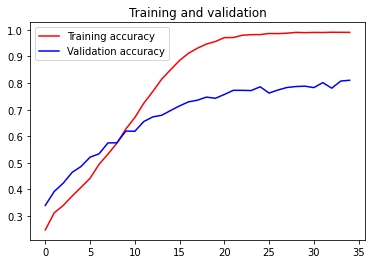

<Figure size 432x288 with 0 Axes>

batchesTrain/13/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 74s 160ms/step - loss: 2.1164 - accuracy: 0.2292 - val_loss: 1.4988 - val_accuracy: 0.3580

Epoch 00001: val_loss improved from inf to 1.49878, saving model to drive/MyDrive/models/modelBatch13.h5
Epoch 2/35
398/398 [==============================] - 60s 150ms/step - loss: 1.7827 - accuracy: 0.3043 - val_loss: 1.3843 - val_accuracy: 0.4036

Epoch 00002: val_loss improved from 1.49878 to 1.38433, saving model to drive/MyDrive/models/modelBatch13.h5
Epoch 3/35
398/398 [==============================] - 60s 150ms/step - loss: 1.6405 - accuracy: 0.3438 - val_loss: 1.3217 - val_accuracy: 0.4335

Epoch 00003: val_loss improved from 1.38433 to 1.32171, saving model to drive/MyDrive/models/modelBatch13.h5
Epoch 4/35
398/398 [==============================] - 60s 150ms/step - loss: 1.5151 - accuracy: 0.3892 - val_loss: 1.2802 - val_accuracy:

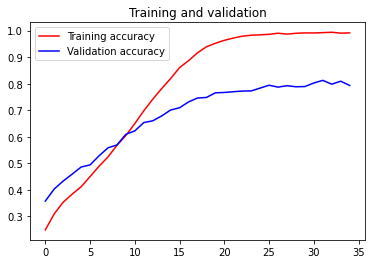

<Figure size 432x288 with 0 Axes>

batchesTrain/14/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 75s 163ms/step - loss: 2.1533 - accuracy: 0.2310 - val_loss: 1.5019 - val_accuracy: 0.3567

Epoch 00001: val_loss improved from inf to 1.50193, saving model to drive/MyDrive/models/modelBatch14.h5
Epoch 2/35
398/398 [==============================] - 60s 151ms/step - loss: 1.7571 - accuracy: 0.3147 - val_loss: 1.3532 - val_accuracy: 0.4205

Epoch 00002: val_loss improved from 1.50193 to 1.35319, saving model to drive/MyDrive/models/modelBatch14.h5
Epoch 3/35
398/398 [==============================] - 60s 151ms/step - loss: 1.5965 - accuracy: 0.3670 - val_loss: 1.2857 - val_accuracy: 0.4571

Epoch 00003: val_loss improved from 1.35319 to 1.28570, saving model to drive/MyDrive/models/modelBatch14.h5
Epoch 4/35
398/398 [==============================] - 60s 150ms/step - loss: 1.5188 - accuracy: 0.3919 - val_loss: 1.2309 - val_accuracy:

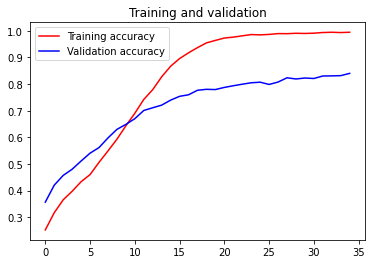

<Figure size 432x288 with 0 Axes>

batchesTrain/15/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 76s 163ms/step - loss: 2.3035 - accuracy: 0.2322 - val_loss: 1.5767 - val_accuracy: 0.3411

Epoch 00001: val_loss improved from inf to 1.57667, saving model to drive/MyDrive/models/modelBatch15.h5
Epoch 2/35
398/398 [==============================] - 61s 154ms/step - loss: 1.7544 - accuracy: 0.3128 - val_loss: 1.3779 - val_accuracy: 0.4366

Epoch 00002: val_loss improved from 1.57667 to 1.37792, saving model to drive/MyDrive/models/modelBatch15.h5
Epoch 3/35
398/398 [==============================] - 61s 154ms/step - loss: 1.6167 - accuracy: 0.3550 - val_loss: 1.2976 - val_accuracy: 0.4616

Epoch 00003: val_loss improved from 1.37792 to 1.29758, saving model to drive/MyDrive/models/modelBatch15.h5
Epoch 4/35
398/398 [==============================] - 61s 153ms/step - loss: 1.5145 - accuracy: 0.3901 - val_loss: 1.2367 - val_accuracy:

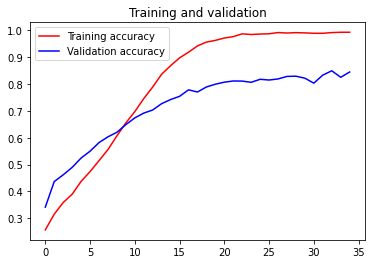

<Figure size 432x288 with 0 Axes>

batchesTrain/16/
Found 12750 images belonging to 5 classes.
Found 2250 images belonging to 5 classes.
Epoch 1/35
398/398 [==============================] - 74s 160ms/step - loss: 2.1643 - accuracy: 0.2266 - val_loss: 1.5270 - val_accuracy: 0.3379

Epoch 00001: val_loss improved from inf to 1.52698, saving model to drive/MyDrive/models/modelBatch16.h5
Epoch 2/35
398/398 [==============================] - 61s 153ms/step - loss: 1.8083 - accuracy: 0.2996 - val_loss: 1.4018 - val_accuracy: 0.3915

Epoch 00002: val_loss improved from 1.52698 to 1.40181, saving model to drive/MyDrive/models/modelBatch16.h5
Epoch 3/35
398/398 [==============================] - 61s 152ms/step - loss: 1.6674 - accuracy: 0.3481 - val_loss: 1.3341 - val_accuracy: 0.4371

Epoch 00003: val_loss improved from 1.40181 to 1.33408, saving model to drive/MyDrive/models/modelBatch16.h5
Epoch 4/35
398/398 [==============================] - 60s 151ms/step - loss: 1.5580 - accuracy: 0.3805 - val_loss: 1.2704 - val_accuracy:

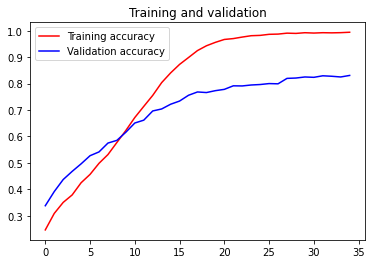

<Figure size 432x288 with 0 Axes>

In [ ]:
# create 16 models using the densenet architecture
# at first create the model
models_path = 'models'
from keras.preprocessing.image import ImageDataGenerator
import numpy
import math
for i in range(1,17):
  batchSize = 32
  pathBatch = path_batch_train+'/'+str(i)+'/'
  print(pathBatch)
  # ******** for train dataset

  train_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.15
      ) 

  train_generator = train_datagen.flow_from_directory(
      pathBatch,
      classes = ['0','1','2','3','4'],
      target_size=(224, 224),
      color_mode='rgb',
      batch_size=batchSize,
      class_mode='categorical',
      subset='training',
      shuffle=True)

  # ******* for validation dataset
  val_generator = train_datagen.flow_from_directory(
      pathBatch,
      classes = ['0','1','2','3','4'],
      class_mode='categorical',
      target_size=(224, 224),
      color_mode='rgb',
      subset='validation'
  )
  model = createModel()
  # 
  earlystopper = EarlyStopping(
            monitor = "val_loss",
            mode="min",
            patience=10,
            verbose=1
  )
  model_checkpoint = ModelCheckpoint(
              'drive/MyDrive/models/modelBatch'+str(i)+'.h5',
              monitor='val_loss',
              verbose=1,
              save_best_only=True
  )
  model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  #history = numpy.empty(16, dtype=object)
  history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples//batchSize),
    epochs=35,
    validation_data = val_generator,
    validation_steps = math.ceil(val_generator.samples//batchSize),callbacks=[model_checkpoint,earlystopper],
    verbose = 1)
  import matplotlib.pyplot as plt
  %matplotlib inline

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  #plt.plot(epochs, loss, 'g', label='Training loss')
  #plt.plot(epochs, val_loss, 'y', label='Validation loss')
  plt.title('Training and validation')
  plt.legend(loc=0)
  plt.figure()
  plt.savefig('results/batch'+str(i)+'.png')
  plt.show()

  if(i==2):
    try:
      import numpy as np
      import matplotlib.pyplot as plt
      from sklearn.metrics import confusion_matrix,classification_report
      probabilities = model.predict_generator(val_generator)
      y_true = val_generator.classes
      y_pred = np.argmax(probabilities, axis=1)
      font = {
      'family': 'Times New Roman',
      'size': 12
      }
      plt.rc('font', **font)
      mat = confusion_matrix(y_true, y_pred)
      print(mat)
      class_labels = list(val_generator.class_indices.keys())
      report = classification_report(y_true, y_pred, target_names=class_labels)
      print(report)
    except Exception:
      pass


In [ ]:


from tensorflow import keras
# function to predict classes of given batches usin the given model
def predictBatch(pathModel,pathTest):
  # load the model 
  from tensorflow import keras
  model = keras.models.load_model(pathModel)
  import numpy as np
  # read images
  test_datagen = ImageDataGenerator(
    #preprocessing_function = preprocessFunction,
    rescale=1./255)
  test_generator = test_datagen.flow_from_directory(
    pathTest,
    classes = ['0','1','2','3','4'],
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False)

  probabilities = model.predict_generator(test_generator)
  y_pred = np.argmax(probabilities, axis=1)
  return y_pred

# function to read images by batch
def readImagesBatch(pathBatch,number_class):
  for i in range(number_class):
    newPath = pathBatch+'/'+ str(i)
    list_dir =  os.listdir(newPath)
    images = []
    for image in list_dir:
      img = cv2.imread(newPath+'/'+image)
      img = cv2.resize(img, dsize=(244, 244))
      images.append(img)
    return images

# to get images information we need only one batch (because one batch contains all images)
def getImagesInformations(pathFirstBatch):
  img_name = []
  img_class = np.zeros((500,18), dtype=int)
  for i in range(5):
    newPath = pathFirstBatch + str(i)
    list_dir =  os.listdir(newPath)
    j = 499
    for image in list_dir:
      img_name.append(image)
      img_class[j][0] = i
      j = j-1
    return img_name,img_class

# at first we need to get the test images name and the equivalent class label
pathFirstBatch = 'batchesTest/1/'
img_name,img_class = getImagesInformations(pathFirstBatch)
# secondly, we need to predict the label of each batch
path = 'batchesTest/'
pathModels = 'drive/MyDrive/models/modelBatch'
for i in range(1,17):
  # path to the model
  pathModel = pathModels+str(i)+'.h5'
  # read images
  pathBatch = path+str(i)
  #images = readImagesBatch(pathBatch,5)
  # use the predict function
  y_predicted = predictBatch(pathModel,pathBatch)
  # add y_predicted to our vector of results
  img_class[:,i] = y_predicted
print(img_class)

Found 500 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
